# Convolutional Neural Network achieving 93.28% Accuracy on Fashion MNIST using strong Regulariziation and Data Augmentation 

This notebook is applying a CNN model that I built for the CIFAR10 dataset to the Fashion MNIST dataset to test its architecture. The model performs pretty well achieving a 93.28% accuracy on unseen test data. If you wanna checkout the notebook where I built this model and explained how I chose the hyperparameters, click on this link: https://github.com/sid2412/CIFAR10-CNN/blob/master/CIFAR10_CNN_model.ipynb


### Import the required libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv


### Read the Train and Test data

In [2]:
train_df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

In [3]:
print(train_df.shape)
train_df.head()

(60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(test_df.shape)
test_df.head()

(10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Convert train and test df to array and normalize it by dividing it by 255.0 so that all our values are between 0 and 1

In [5]:
train_df = np.array(train_df, dtype='float32')
test_df = np.array(test_df, dtype='float32')

In [6]:
X_train = train_df[:,1:] / 255.0
X_test = test_df[:,1:] / 255.0

y_train = train_df[:,0]
y_test = test_df[:, 0]

### Further splitting the training data to create a validation set to test model performance

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=36)

In [8]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize a few images to get a feel of the dataset

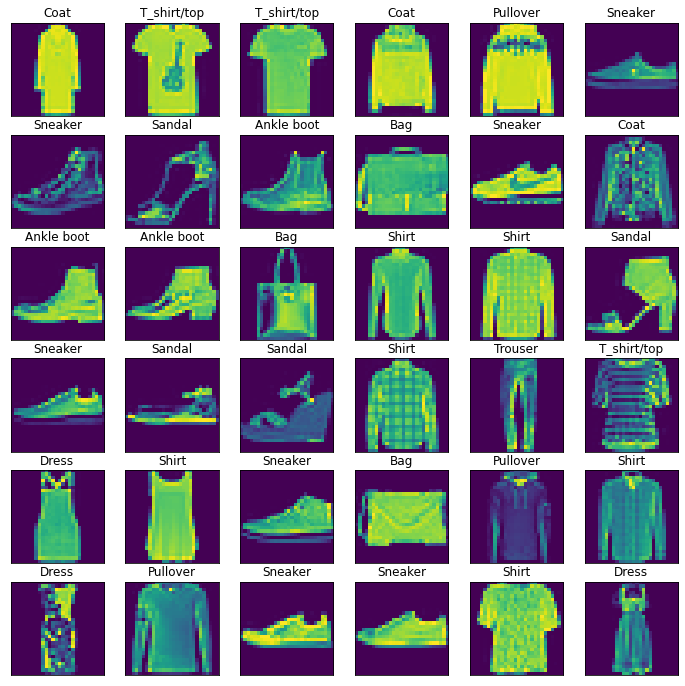

In [9]:
plt.figure(figsize=(12,12))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(X_train[i].reshape(28,28))
    index = int(y_train[i])
    plt.title(class_names[index])
    plt.xticks([])
    plt.yticks([])
plt.show()

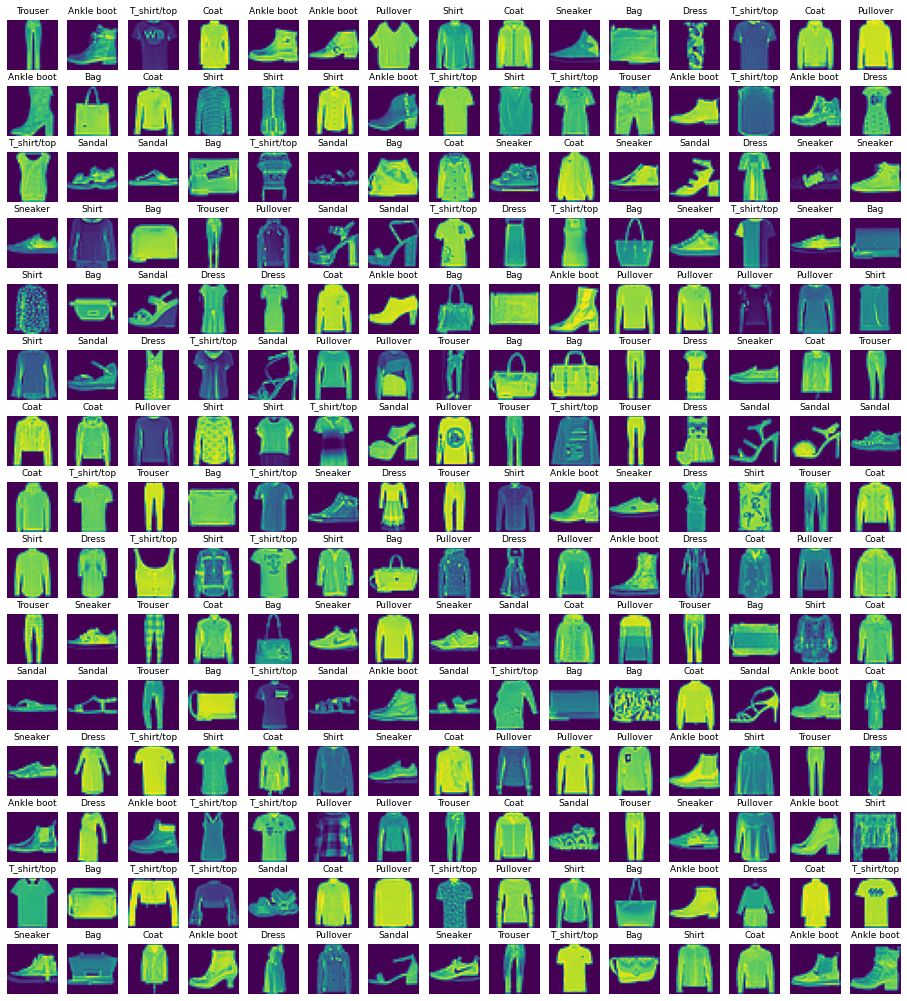

<Figure size 432x288 with 0 Axes>

In [10]:
fig, axes = plt.subplots(15, 15, figsize=(16,18))
axes = axes.ravel()
n_train = len(train_df)

for i in range(225):
    index = np.random.randint(0, n_train)
    axes[i].imshow(train_df[index,1:].reshape(28,28))
    label_index = int(train_df[index,0])
    axes[i].set_title(class_names[label_index], fontsize=9)
    axes[i].axis('off')
plt.show()
plt.tight_layout()

### Reshape the data to the required format for Neural Networks [batch_size, width, height, channels]

In [11]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)

### Define the model

In [13]:
def cnn_model():
    
    model = Sequential()
    
    # First Conv layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Second Conv layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
     # Third, fourth, fifth convolution layer
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully Connected layers
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    
    return model

### Data Augmentation to introduce variations in the dataset and make the model more robust and generalize better

In [14]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train)

In [15]:
model = cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 512)         1

### Compile the model

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(lr=0.0003, decay=1e-6),
             metrics=['accuracy'])

### Fit the model

In [17]:
history = model.fit(datagen.flow(X_train, y_train, batch_size = 64),
                    steps_per_epoch = len(X_train) // 64, 
                    epochs = 125, 
                    validation_data= (X_valid, y_valid),
                    verbose=1)

Epoch 1/125
750/750 [==============================] - 19s 25ms/step - loss: 1.2807 - accuracy: 0.5494 - val_loss: 0.7206 - val_accuracy: 0.7451
Epoch 2/125
750/750 [==============================] - 19s 26ms/step - loss: 0.7295 - accuracy: 0.7554 - val_loss: 0.5427 - val_accuracy: 0.8099
Epoch 3/125
750/750 [==============================] - 18s 24ms/step - loss: 0.6373 - accuracy: 0.7898 - val_loss: 0.5141 - val_accuracy: 0.8337
Epoch 4/125
750/750 [==============================] - 18s 24ms/step - loss: 0.5770 - accuracy: 0.8178 - val_loss: 0.4749 - val_accuracy: 0.8539
Epoch 5/125
750/750 [==============================] - 19s 26ms/step - loss: 0.5359 - accuracy: 0.8367 - val_loss: 0.4309 - val_accuracy: 0.8680
Epoch 6/125
750/750 [==============================] - 19s 25ms/step - loss: 0.5051 - accuracy: 0.8490 - val_loss: 0.4360 - val_accuracy: 0.8753
Epoch 7/125
750/750 [==============================] - 18s 24ms/step - loss: 0.4867 - accuracy: 0.8562 - val_loss: 0.3968 - val_ac

750/750 [==============================] - 19s 25ms/step - loss: 0.3027 - accuracy: 0.9230 - val_loss: 0.3100 - val_accuracy: 0.9204
Epoch 113/125
750/750 [==============================] - 18s 24ms/step - loss: 0.2990 - accuracy: 0.9249 - val_loss: 0.3004 - val_accuracy: 0.9257
Epoch 114/125
750/750 [==============================] - 18s 24ms/step - loss: 0.3046 - accuracy: 0.9229 - val_loss: 0.3080 - val_accuracy: 0.9227
Epoch 115/125
750/750 [==============================] - 18s 24ms/step - loss: 0.3015 - accuracy: 0.9254 - val_loss: 0.2931 - val_accuracy: 0.9276
Epoch 116/125
750/750 [==============================] - 19s 25ms/step - loss: 0.2975 - accuracy: 0.9258 - val_loss: 0.3018 - val_accuracy: 0.9260
Epoch 117/125
750/750 [==============================] - 18s 24ms/step - loss: 0.2974 - accuracy: 0.9260 - val_loss: 0.2933 - val_accuracy: 0.9277
Epoch 118/125
750/750 [==============================] - 18s 24ms/step - loss: 0.3031 - accuracy: 0.9255 - val_loss: 0.2965 - val_ac

### Plotting the train and val accuracy & loss

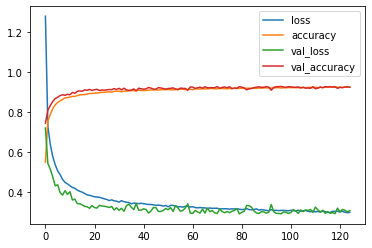

In [18]:
pd.DataFrame(history.history).plot()

### Evaluate model on the test set

In [19]:
scores = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.2850 - accuracy: 0.9328


### Generate predictions

In [20]:
pred = model.predict(X_test)

In [21]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

y_pred = np.argmax(pred, axis=1)

### Classification report to understand how the model is performing on every class

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      1000
         1.0       0.97      1.00      0.99      1000
         2.0       0.94      0.87      0.90      1000
         3.0       0.94      0.93      0.93      1000
         4.0       0.89      0.92      0.90      1000
         5.0       0.98      0.99      0.98      1000
         6.0       0.78      0.84      0.81      1000
         7.0       0.95      0.97      0.96      1000
         8.0       0.99      0.99      0.99      1000
         9.0       0.98      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



### Visualize the true and predicted label

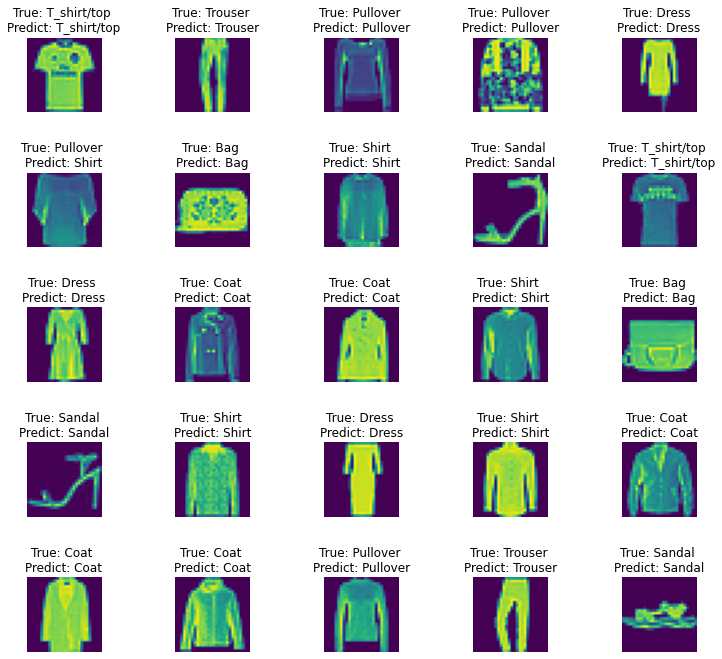

In [26]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title('True: %s \nPredict: %s' % (class_names[int(y_test[i])], class_names[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

### Visualize the misclassified labels 

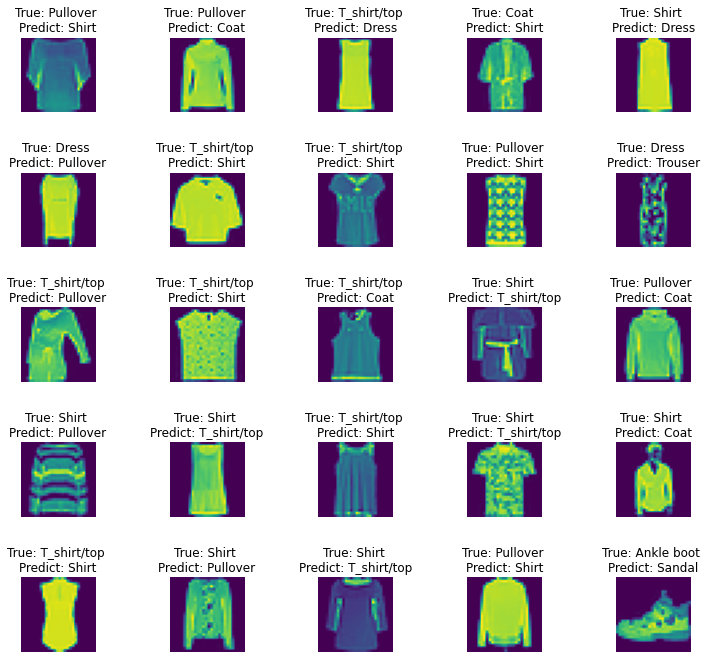

In [31]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

miss_pred = np.where(y_pred != y_test)[0]
for i in np.arange(25):
    axes[i].imshow(X_test[miss_pred[i]].reshape(28,28))
    axes[i].set_title('True: %s \nPredict: %s' % (class_names[int(y_test[miss_pred[i]])],
                                                 class_names[y_pred[miss_pred[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)